**Moisture Budget Derivations**

Based on Trenberth and Guillemot 1995 and using somewhat similar notation.

∇∙$\vec{V}$ + ∂ω/∂p = 0  continuity equation (eqn 1)

Where V = u$\hat{i}$ + v$\hat{j}$, ω is the vertical velocity on pressure coordinate (Pa/s), and p is the pressure level (Pa).

w = ∫$_0^∞$qρdz (eqn 2)

Where w the precipitable water defined as the vertical mass-weighted integral of specific humidity q (kg/kg) and ρ is the density of the air.

Employing the hydrostatic balance dp/dz = -gρ this can be written as:

w = ∫$_0^∞$qρdz = 1/g ∫$_0^{p_s}$qρdp (eqn 3)

Where p_s is the surface pressure. *Note the minus sign disappears because the bounds of the integral are flipped. 

Starting with the conservation of water vapor equation:

∂q/∂t + $\vec{V}$∙∇q + ω ∂q/∂p = e-c (eqn 4)

Where e is evaporation and c is condensation.

∇∙(q$\vec{V}$) = q∇∙$\vec{V}$ + $\vec{V}$∙∇q, using the continuity equation (eqn 1) ∇∙(q$\vec{V}$) = -q∂ω/∂p + $\vec{V}$∙∇q, or $\vec{V}$∙∇q = ∇∙(q$\vec{V}$) + q∂ω/∂p. Substituting this, eqn 4 can be expressed in flux form:

∂q/∂t + ∇∙(q$\vec{V}$) + q∂ω/∂p + ω∂q/∂p = ∂q/∂t + ∇∙q$\vec{V}$ + ∂(ωq)/∂p = e-c (eqn 5)

For the vertical integral of eqn 5

1/g∫$_0^{p_s}$∂q/∂tdp + 1/g∫$_0^{p_s}$∇∙(q$\vec{V}$)dp + 1/g∫$_0^{p_s}$∂(ωq)/∂pdp = E-P (eqn 6)

Noting the generic relationship for any A

∂(∫$_0^{p_s}$qdp)/∂t = ∫$_0^{p_s}$∂A/∂tdp + $A_s$∂$p_s$/∂t   Leibniz integral rule (eqn 7a)

∇∙∫$_0^{p_s}$A$\vec{V}$dp = ∫$_0^{p_s}$∇∙(q$\vec{V}$)dp + A_s$\vec{V}_s$∙∇$p_s$   Leibniz integral rule (eqn 7b)

∫$_0^{p_s}$∂Aω/∂pdp = $A_s$$ω_s$ = $A_s$(∂$p_s$/∂t + $\vec{V}_s$∙∇$p_s$) (eqn 7c)

Equ 6 can be rewritten as

∂(1/g∫$_0^{p_s}$qdp)/∂t  - 1/g$q_s$∂$p_s$/∂t + ∇∙1/g∫$_0^{p_s}$q$\vec{V}$dp - 1/g$q_s$$\vec{V}_s$∙∇$p_s$ + 1/gq∂$p_s$/∂t   + 1/gq$\vec{V}_s$∙∇$p_s$ =

∂(1/g∫$_0^{p_s}$qdp)/∂t + ∇∙1/g∫$_0^{p_s}$q$\vec{V}$dp = E-P 

∂w/∂t + ∇∙1/g∫$_0^{p_s}$q$\vec{V}$dp = E-P (eqn 8)


In [92]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import Ngl

In [93]:
def spheric_dist(lat1,lat2,lon1,lon2):

    R=6367442.76
    # %  Determine proper longitudinal shift.

    l=np.absolute(lon2-lon1)

    l[l>=180]=360-l[l>=180]

    #                  
    #   Convert Decimal degrees to radians.
    # 
    deg2rad=np.pi/180
    lat1=lat1*deg2rad
    lat2=lat2*deg2rad
    l=l*deg2rad

    # 
    #   Compute the distances using Haversine formula
    # 
    
    dist=R*np.arcsin(np.sqrt(((np.sin(l)*np.cos(lat2))**2)+(((np.sin(lat2)*np.cos(lat1))-(np.sin(lat1)*np.cos(lat2)*np.cos(l)))**2)))

    return dist

In [94]:
def get_grid_area(lon_rho,lat_rho):

    I, J=lon_rho.shape
    lon_u=np.zeros((I+1,J))
    lon_u[1:-1,:]=0.5*(lon_rho[0:-1,:]+lon_rho[1:,:])
    lon_u[0,:]=lon_rho[0,:]-0.5*(lon_rho[1,:]-lon_rho[0,:])
    lon_u[-1,:]=lon_rho[-1,:]+0.5*(lon_rho[-1,:]-lon_rho[-2,:])

    lat_u=np.zeros((I+1,J))
    lat_u[1:-1,:]=0.5*(lat_rho[0:-1,:]+lat_rho[1:,:])
    lat_u[0,:]=lat_rho[0,:]-0.5*(lat_rho[1,:]-lat_rho[0,:])
    lat_u[-1,:]=lat_rho[-1,:]+0.5*(lat_rho[-1,:]-lat_rho[-2,:])

    lon_v=np.zeros((I,J+1))
    lon_v[:,1:-1]=0.5*(lon_rho[:,0:-1]+lon_rho[:,1:])
    lon_v[:,0]=lon_rho[:,0]-0.5*(lon_rho[:,1]-lon_rho[:,0])
    lon_v[:,-1]=lon_rho[:,-1]+0.5*(lon_rho[:,-1]-lon_rho[:,-2])

    lat_v=np.zeros((I,J+1))
    lat_v[:,1:-1]=0.5*(lat_rho[:,0:-1]+lat_rho[:,1:])
    lat_v[:,0]=lat_rho[:,0]-0.5*(lat_rho[:,1]-lat_rho[:,0])
    lat_v[:,-1]=lat_rho[:,-1]+0.5*(lat_rho[:,-1]-lat_rho[:,-2])

    dx_rho=np.zeros((I,J))
    dx_rho=spheric_dist(lat_u[0:-1,:],lat_u[1:,:],lon_u[0:-1,:],lon_u[1:,:])
    dy_rho=np.zeros((I,J))
    dy_rho=spheric_dist(lat_v[:,0:-1],lat_v[:,1:], lon_v[:,0:-1],lon_v[:,1:])

    A=dy_rho*dx_rho
    return (A, dx_rho, dy_rho)

In [95]:
def meridi_moist_div(VQBar,dp):
    
    g = 9.81 # gravitational constant
    rho_fw = 1000.0; # density of fresh water (kg/m^3)
    
    # Vertically integrate
    VQBardp = VQBar*dp;  # kg/kg m/s Pa
    dp_naned = np.where(np.isnan(VQBardp),np.nan,dp)
    VQBar_2D = np.nansum(VQBardp,0)/np.nansum(dp_naned,0)*1000; #convert to g/kg m/s
    
    VQBar_vertinterp = (1/g)*np.nansum(VQBardp,0); # in kg/m/s (kg/kg m/s Pa s^2/m -> kg/kg m/s kg/m/s^2 s^2/m) 
    # VQBar_vertinterp has the units of kg/m/s 
    # convert to m^2/s by dividing by water density and then multiply by y or x distance (m) to get m^3/s
    VQBar_vertinterp_mid = VQBar_vertinterp[0:-1,:]+((VQBar_vertinterp[1:,:]-VQBar_vertinterp[0:-1,:])/dy_mid)*0.5*dy[0:-1,:];

    VQBar_transport = np.zeros([nlat+1,nlon])
    VQBar_transport[1:-1,:] = VQBar_vertinterp_mid/rho_fw*dx_midy; # m^3/s
    
    VQBar_div = VQBar_transport[1:,:]-VQBar_transport[0:-1,:]; # m^3/s

    return (VQBar_transport, VQBar_div)

In [96]:
def zonal_moist_div(UQBar,dp):

    g = 9.81 #gravitational constant
    rho_fw = 1000.0;      # density of fresh water (kg/m^3)
    
    # Vertically integrate
    UQBardp = UQBar*dp;  # kg/kg m/s Pa
    dp_naned = np.where(np.isnan(UQBardp),np.nan,dp)
    UQBar_2D = np.nansum(UQBardp,0)/np.nansum(dp_naned,0)*1000; #convert to g/kg m/s
    
    UQBar_vertinterp = (1/g)*np.nansum(UQBardp,0); # in kg/m/s (kg/kg m/s Pa s^2/m -> kg/kg m/s kg/m/s^2 s^2/m) 
    # UQBar_vertinterp has the units of kg/m/s 
    # convert to m^2/s by dividing by water density and then multiply by y or x distance (m) to get m^3/s
    UQBar_vertinterp_mid = UQBar_vertinterp[:,0:-1]+((UQBar_vertinterp[:,1:]-UQBar_vertinterp[:,0:-1])/dx_mid)*0.5*dx[:,0:-1];
    UQBar_vertinterp_wrap = UQBar_vertinterp[:,-1]+(UQBar_vertinterp[:,0]-UQBar_vertinterp[:,-1])/((dx[:,0]+dx[:,-1])/2)*0.5*dx[:,-1];
    
    UQBar_transport = np.zeros([nlat,nlon+1])
    UQBar_transport[:,1:-1] = UQBar_vertinterp_mid/rho_fw*dy_midx; # m^3/s
    UQBar_transport[:,0] = UQBar_vertinterp_wrap/rho_fw*(dy[:,0]+dy[:,-1])/2; 
    UQBar_transport[:,-1] = UQBar_vertinterp_wrap/rho_fw*(dy[:,0]+dy[:,-1])/2; 

    UQBar_div = UQBar_transport[:,1:]-UQBar_transport[:,0:-1]; # m^3/s
    
    return (UQBar_transport, UQBar_div)

In [97]:
def read_CAM_moist_flux_feilds(file):
    
    ds=xr.open_dataset(file)
    
    p = (ds.hyam*ds.P0 + ds.hybm*ds.PS[0,:,:])#mid-point pressure in Pa (ref P0 = 100000Pa)
    # 0 is TOA and -1 is surface
    
    # pressure at interface
    p_i = (ds.hyai*ds.P0 + ds.hybi*ds.PS[0,:,:])# interface pressure in Pa (ref P0 = 100000Pa)
    
    PS = ds.PS[0,:,:] # Pa
    P = (ds.PRECC[0,:,:]+ds.PRECL[0,:,:])*1000 # m/s x 1000 kg/m^3 = kg/m^2/s
    E = ds.QFLX[0,:,:] # kg/m2/s
    
    Q = ds.Q[0,:,:,:]  # kg/kg
    V = ds.V[0,:,:,:]  # m/s 
    U = ds.U[0,:,:,:]  # m/s
    VQbar = ds.VQ[0,:,:,:] # m/s kg/kg 
    UQbar = ds.UQ[0,:,:,:] # m/s kg/kg
    
    lon = ds.lon
    lat = ds.lat
    [nlvl,nlat,nlon] = V.shape
    
    return (p,p_i,PS,P,E,Q,V,U,VQbar,UQbar,lon,lat,nlvl,nlat,nlon)

In [98]:
path='/homes/nburls/MoistureBudgetInMatlab/'
cnt_file='Control_SSTs_CAM5_0.9x1.25_gx1v6.cam.h0.0021-0120._ANN_climatology.nc'
exp_file='PlioceneAno_SSTs_CAM5_0.9x1.25_gx1v6.cam.h0.0021-0120._ANN_climatology.nc'

In [123]:
[p_cnt,p_i_cnt,PS_cnt,P_cnt,E_cnt,Q_cnt,V_cnt,U_cnt,VQbar_cnt,UQbar_cnt,lon,lat,nlvl,nlat,nlon]=read_CAM_moist_flux_feilds(cnt_file)
[p_exp,p_i_exp,PS_exp_exp,P_exp,E_exp,Q_exp,V_exp,U_exp,VQbar_exp,UQbar_exp,lon,lat,nlvl,nlat,nlon]=read_CAM_moist_flux_feilds(exp_file)

In [100]:
# estimate of pressure at interface (not needed for CAM but perhaps for other models)
p_i_est_cnt = np.empty([nlvl+1,nlat,nlon]) #p_i_est=xr.zeros_like(p_i)
p_i_est_cnt[1:-1,:,:] = (p_cnt[0:-1,:,:].values+p_cnt[1:,:,:].values)/2
p_i_est_cnt[0,:,:] =  p_i_cnt[0,:,:]
p_i_est_cnt[-1,:,:] = PS_cnt

In [101]:
#plt.plot(p_i[:,:,:].mean(axis=2).mean(axis=1))
#plt.plot(np.nanmean(np.nanmean(p_i_est[:,:,:],axis=2),axis=1))
#plt.contourf(p_i_est[-1,:,:])
#plt.colorbar()

In [102]:
# Calculate the pressure change (dp) for each grid cell
dp_cnt = p_i_cnt[1:,:,:].values-p_i_cnt[0:-1,:,:].values
dp_exp = p_i_exp[1:,:,:].values-p_i_exp[0:-1,:,:].values

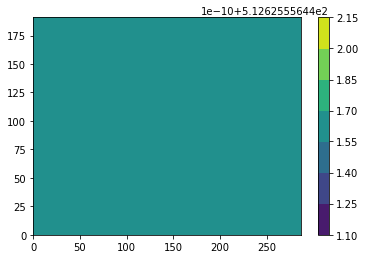

In [103]:
plt.contourf(dp_cnt[1,:,:])
plt.colorbar()

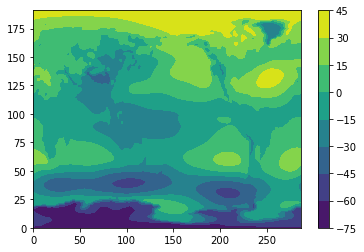

In [104]:
test_dp_diff=dp_cnt-dp_exp
plt.contourf(test_dp_diff[-15,:,:])
plt.colorbar()

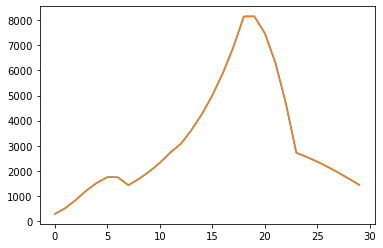

In [105]:
plt.plot(dp_cnt[:,:,:].mean(axis=2).mean(axis=1))
plt.plot(dp_exp[:,:,:].mean(axis=2).mean(axis=1))

In [106]:
# Calculate dx, dy and Area 
[lat_rho,lon_rho]=np.meshgrid(lat,lon);
(A, dx, dy)=get_grid_area(lon_rho,lat_rho)
A = np.swapaxes(A,0,1)
dx = np.swapaxes(dx,0,1)
dy = np.swapaxes(dy,0,1)

In [107]:
dx_midy = (dx[0:-1,:]+dx[1:,:])/2;
dy_midx = (dy[:,0:-1]+dy[:,1:])/2; 
dx_mid = (dx[:,0:-1]+dx[:,1:])/2;
dy_mid = (dy[0:-1,:]+dy[1:,:])/2; 

In [108]:
#plt.contourf(lon,lat,A)
#plt.contourf(lon,lat,dx)
#plt.contourf(lat,lon,dy)
#plt.contourf(dx_midy)
#plt.contourf(dy_midx)
#plt.contourf(dx_mid)
#plt.contourf(dy_mid)
#plt.colorbar()

**Decomp of Control Simulation** 

In [109]:
(VQbar_transport_cnt, VQbar_div_cnt) = meridi_moist_div(VQbar_cnt,dp_cnt)
VbarQbar_cnt=V_cnt*Q_cnt
(VbarQbar_transport_cnt, VbarQbar_div_cnt) = meridi_moist_div(VbarQbar_cnt,dp_cnt)
VpQpBar_div_cnt=VQbar_div_cnt-VbarQbar_div_cnt

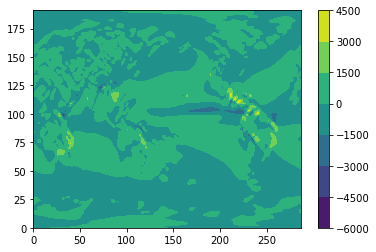

In [110]:
plt.contourf(VQbar_div_cnt)
plt.colorbar()

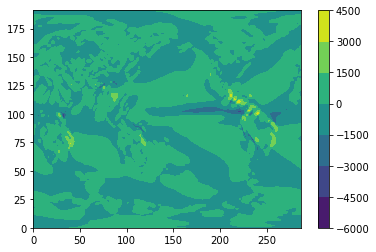

In [111]:
plt.contourf(VbarQbar_div_cnt)
plt.colorbar()

In [112]:
(UQbar_transport_cnt, UQbar_div_cnt) = zonal_moist_div(UQbar_cnt,dp_cnt)
UbarQbar_cnt=U_cnt*Q_cnt
(UbarQbar_transport_cnt, UbarQbar_div_cnt) = zonal_moist_div(UbarQbar_cnt,dp_cnt)
UpQpBar_div_cnt=UQbar_div_cnt-UbarQbar_div_cnt

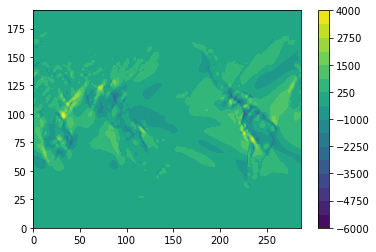

In [113]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UQbar_div_cnt,clev)
plt.colorbar()

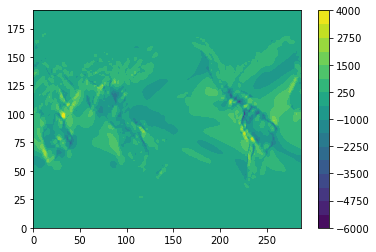

In [114]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UbarQbar_div_cnt,clev)
plt.colorbar()

In [115]:
#plt.contourf(lon,lat,VQBardp[1,:,:])
#plt.contourf(lon,lat,VQBar_vertinterp)
#plt.contourf(lon,lat,dp_naned[-1,:,:])
#plt.contourf(VQBar_div)
#plt.colorbar()

In [116]:
Moisture_Div_cnt = (UQbar_div_cnt+VQbar_div_cnt)/A; #m/s 
#Moisture_Div[0,:] = 0; Moisture_Div[-1,:] = 0; # set moisture div to zero at poles
Moisture_Div_mean_cnt = (UbarQbar_div_cnt+VbarQbar_div_cnt)/A; #m/s 
Moisture_Div_eddy_cnt = (UpQpBar_div_cnt+VpQpBar_div_cnt)/A; #m/s

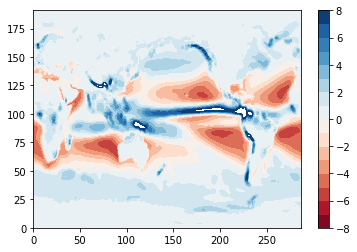

In [117]:
clev=np.linspace(-8,8,17)
plt.contourf((P_cnt-E_cnt)*86400,clev,cmap='RdBu') #convert from kg/m^2/s to mm/day -> ./1000.*1000.*86400
plt.colorbar()

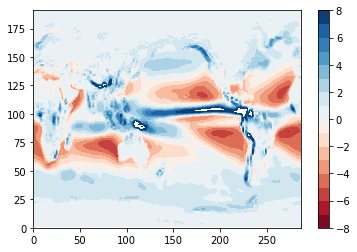

In [118]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_cnt*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

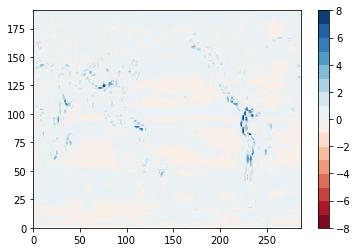

In [119]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_cnt*86400*1000-((P_cnt-E_cnt)*86400),clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

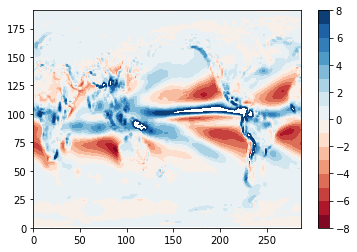

In [120]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_mean_cnt*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

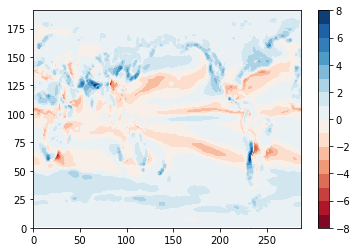

In [121]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_eddy_cnt*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

**Decomp of Pliocene Simulation** 

In [124]:
(VQbar_transport_exp, VQbar_div_exp) = meridi_moist_div(VQbar_exp,dp_exp)
VbarQbar_exp=V_exp*Q_exp
(VbarQbar_transport_exp, VbarQbar_div_exp) = meridi_moist_div(VbarQbar_exp,dp_exp)
VpQpBar_div_exp=VQbar_div_exp-VbarQbar_div_exp

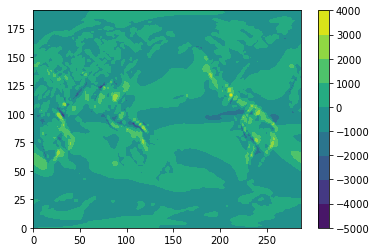

In [125]:
plt.contourf(VQbar_div_exp)
plt.colorbar()

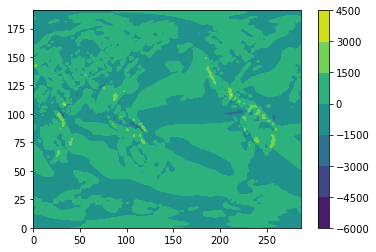

In [126]:
plt.contourf(VbarQbar_div_exp)
plt.colorbar()

In [127]:
(UQbar_transport_exp, UQbar_div_exp) = zonal_moist_div(UQbar_exp,dp_exp)
UbarQbar_exp=U_exp*Q_exp
(UbarQbar_transport_exp, UbarQbar_div_exp) = zonal_moist_div(UbarQbar_exp,dp_exp)
UpQpBar_div_exp=UQbar_div_exp-UbarQbar_div_exp

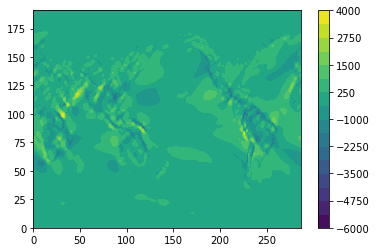

In [128]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UQbar_div_exp,clev)
plt.colorbar()

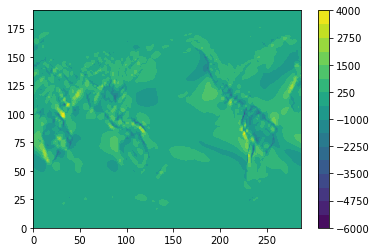

In [129]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UbarQbar_div_exp,clev)
plt.colorbar()

In [130]:
#plt.contourf(lon,lat,VQBardp[1,:,:])
#plt.contourf(lon,lat,VQBar_vertinterp)
#plt.contourf(lon,lat,dp_naned[-1,:,:])
#plt.contourf(VQBar_div)
#plt.colorbar()

In [131]:
Moisture_Div_exp = (UQbar_div_exp+VQbar_div_exp)/A; #m/s 
#Moisture_Div[0,:] = 0; Moisture_Div[-1,:] = 0; # set moisture div to zero at poles
Moisture_Div_mean_exp = (UbarQbar_div_exp+VbarQbar_div_exp)/A; #m/s 
Moisture_Div_eddy_exp = (UpQpBar_div_exp+VpQpBar_div_exp)/A; #m/s

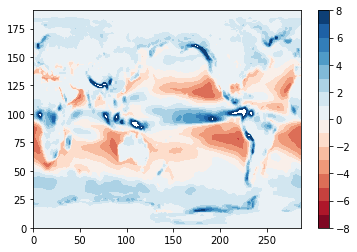

In [132]:
clev=np.linspace(-8,8,17)
plt.contourf((P_exp-E_exp)*86400,clev,cmap='RdBu') #convert from kg/m^2/s to mm/day -> ./1000.*1000.*86400
plt.colorbar()

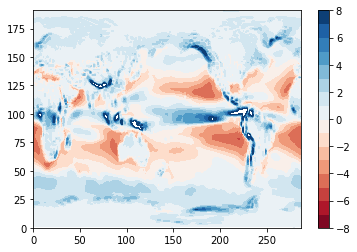

In [133]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

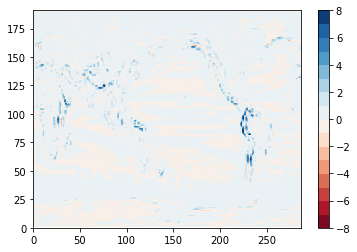

In [134]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_exp*86400*1000-((P_exp-E_exp)*86400),clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

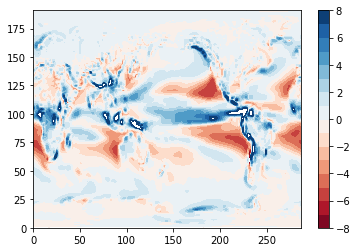

In [135]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_mean_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

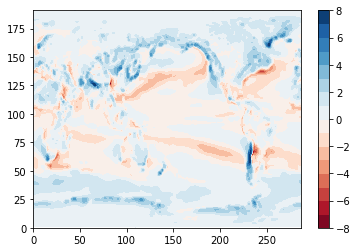

In [136]:
clev=np.linspace(-8,8,17)
plt.contourf(-Moisture_Div_eddy_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()